# Goal of this notebook is to try to find which data points are anomalies using simple autoencoder architecture.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Load data

In [2]:
try:
    data = loadmat(file_name='satellite.mat')
except FileNotFoundError:
    print('Satellite data not found in directory. Downloading...\n')
    !wget 'https://www.dropbox.com/s/dpzxp8jyr9h93k5/satellite.mat'
    data = loadmat(file_name='satellite.mat')

Satellite data not found in directory. Downloading...

--2020-03-28 10:33:53--  https://www.dropbox.com/s/dpzxp8jyr9h93k5/satellite.mat
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6027:1::a27d:4801, 162.125.72.1
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6027:1::a27d:4801|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/dpzxp8jyr9h93k5/satellite.mat [following]
--2020-03-28 10:33:53--  https://www.dropbox.com/s/raw/dpzxp8jyr9h93k5/satellite.mat
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc489ab8e3d7cca366c42ba00c7d.dl.dropboxusercontent.com/cd/0/inline/A0yjmnHKo7ypihTMVoIy0eXzOi13Pf4mwMegVxD5rX270sUnzdbuhgSG7SWRL1dE5SjLuDzMHxeiH5XTZYCRhih3sIU7XsE1vE6zjaymncrwnA/file# [following]
--2020-03-28 10:33:54--  https://uc489ab8e3d7cca366c42ba00c7d.dl.dropboxusercontent.com/cd/0/inline/A0yjmnHKo7ypihTMVoIy0eXzOi13Pf4mwMegVxD5rX270sUnzdbuhgSG7S

In [3]:
X = data['X']
y = data['y']

In [4]:
column_names = list(str(x) for x in range(X.shape[1]))
column_names.append('anomaly')
df = pd.DataFrame(data=np.hstack((X, y)), columns=column_names)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,anomaly
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,0
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,0
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,0
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,0
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,0


In [6]:
no_samples =  len(df)
no_features = len(df.columns) - 1  # without target column (anomaly or not)

print(f'Number of samples: {no_samples}')
print(f'Number of features: {no_features}')

Number of samples: 6435
Number of features: 36


# Preprocess data (spliting, scaling)

In [7]:
scaler = MinMaxScaler()

In [8]:
X_scaled = scaler.fit_transform(df[df.columns[:-1]])

In [9]:
df_scaled = pd.DataFrame(np.hstack((X_scaled, y)), columns=column_names)

In [10]:
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,anomaly
0,0.815385,0.800000,0.770115,0.504132,0.692308,0.681818,0.589474,0.390625,0.6875,0.728155,...,0.600,0.753846,0.912621,0.821053,0.554688,0.692308,0.776699,0.663158,0.453125,0.0
1,0.692308,0.681818,0.609195,0.380165,0.692308,0.681818,0.547368,0.421875,0.6250,0.728155,...,0.568,0.692308,0.776699,0.663158,0.453125,0.692308,0.699029,0.568421,0.390625,0.0
2,0.692308,0.681818,0.563218,0.413223,0.630769,0.681818,0.547368,0.390625,0.6875,0.650485,...,0.464,0.692308,0.699029,0.568421,0.390625,0.692308,0.699029,0.568421,0.390625,0.0
3,0.630769,0.681818,0.563218,0.380165,0.692308,0.609091,0.547368,0.390625,0.6250,0.650485,...,0.400,0.692308,0.699029,0.568421,0.390625,0.692308,0.737864,0.568421,0.390625,0.0
4,0.692308,0.609091,0.563218,0.380165,0.630769,0.609091,0.505263,0.367188,0.6250,0.728155,...,0.400,0.692308,0.737864,0.568421,0.390625,0.615385,0.776699,0.621053,0.453125,0.0


In [11]:
df_anomalies = df_scaled[df_scaled['anomaly'] == 1]
df_anomalies = df_anomalies[df_anomalies.columns[:-1]]

In [12]:
df_anomalies.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
8,0.569231,0.563636,0.517241,0.355372,0.569231,0.609091,0.505263,0.367188,0.5625,0.689320,...,0.511111,0.368,0.553846,0.621359,0.484211,0.328125,0.615385,0.582524,0.452632,0.328125
9,0.569231,0.609091,0.517241,0.355372,0.569231,0.645455,0.547368,0.335938,0.5625,0.650485,...,0.511111,0.336,0.615385,0.582524,0.452632,0.328125,0.615385,0.582524,0.452632,0.296875
10,0.569231,0.645455,0.563218,0.322314,0.569231,0.609091,0.421053,0.367188,0.5625,0.601942,...,0.477778,0.336,0.615385,0.582524,0.452632,0.296875,0.553846,0.582524,0.484211,0.328125
11,0.507692,0.609091,0.425287,0.322314,0.507692,0.563636,0.463158,0.367188,0.5000,0.601942,...,0.511111,0.336,0.553846,0.582524,0.452632,0.296875,0.492308,0.582524,0.410526,0.296875
12,0.507692,0.563636,0.471264,0.355372,0.507692,0.563636,0.505263,0.367188,0.5625,0.650485,...,0.477778,0.304,0.492308,0.582524,0.410526,0.296875,0.492308,0.504854,0.326316,0.257812


In [13]:
df_no_anomalies = df_scaled[df_scaled['anomaly'] == 0]
df_no_anomalies = df_no_anomalies[df_no_anomalies.columns[:-1]]

In [14]:
df_no_anomalies.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.815385,0.800000,0.770115,0.504132,0.692308,0.681818,0.589474,0.390625,0.6875,0.728155,...,0.933333,0.600,0.753846,0.912621,0.821053,0.554688,0.692308,0.776699,0.663158,0.453125
1,0.692308,0.681818,0.609195,0.380165,0.692308,0.681818,0.547368,0.421875,0.6250,0.728155,...,0.866667,0.568,0.692308,0.776699,0.663158,0.453125,0.692308,0.699029,0.568421,0.390625
2,0.692308,0.681818,0.563218,0.413223,0.630769,0.681818,0.547368,0.390625,0.6875,0.650485,...,0.700000,0.464,0.692308,0.699029,0.568421,0.390625,0.692308,0.699029,0.568421,0.390625
3,0.630769,0.681818,0.563218,0.380165,0.692308,0.609091,0.547368,0.390625,0.6250,0.650485,...,0.600000,0.400,0.692308,0.699029,0.568421,0.390625,0.692308,0.737864,0.568421,0.390625
4,0.692308,0.609091,0.563218,0.380165,0.630769,0.609091,0.505263,0.367188,0.6250,0.728155,...,0.600000,0.400,0.692308,0.737864,0.568421,0.390625,0.615385,0.776699,0.621053,0.453125


# Split data without anomalies into train and test dataframes

In [15]:
split_idx = int(0.8 * len(df_no_anomalies))
df_no_anomalies_train = df_no_anomalies.iloc[:split_idx, :]
df_no_anomalies_test = df_no_anomalies.iloc[split_idx:, :]

# Dataset and dataloader

In [16]:
class SatelliteDataset(torch.utils.data.Dataset):
    def __init__(self, features: np.ndarray):
        super(SatelliteDataset, self).__init__()
        self.features = features
        
    def __getitem__(self, idx):
        return torch.tensor(self.features[idx, :])
    
    def __len__(self):
        return self.features.shape[0]

train_ds_no_anomalies = SatelliteDataset(df_no_anomalies_train.values)
test_ds_no_anomalies = SatelliteDataset(df_no_anomalies_test.values)

In [17]:
# Dataloaders
train_dl_no_anomalies = torch.utils.data.DataLoader(train_ds_no_anomalies, shuffle=True, batch_size=1024, num_workers=4)
test_dl_no_anomalies = torch.utils.data.DataLoader(test_ds_no_anomalies, shuffle=True, batch_size=1024, num_workers=4)

In [18]:
# Show first value
for i, x in enumerate(train_dl_no_anomalies):
    print(x)
    print(x.shape)        
    break

tensor([[0.4923, 0.7636, 0.8046,  ..., 0.7379, 0.6737, 0.4766],
        [0.7846, 0.8273, 0.7931,  ..., 0.8544, 0.7263, 0.4766],
        [0.5385, 0.5909, 0.5057,  ..., 0.7379, 0.6105, 0.4609],
        ...,
        [0.1692, 0.4727, 0.5057,  ..., 0.5825, 0.5684, 0.4062],
        [0.2615, 0.3727, 0.3448,  ..., 0.4272, 0.3579, 0.3203],
        [0.6923, 0.6909, 0.6897,  ..., 0.7476, 0.6526, 0.4688]],
       dtype=torch.float64)
torch.Size([1024, 36])


# Build model

In [19]:
class SatelliteAnomalyModel(nn.Module):
    def __init__(self, in_features: int):
        super(SatelliteAnomalyModel, self).__init__()
        self.encoder =  nn.Sequential(
                            nn.Linear(in_features, in_features//2),
                            nn.ReLU(),
                            nn.Linear(in_features//2, in_features//3),
                            nn.ReLU(),
                        )   
        self.decoder = nn.Sequential(
                            nn.Linear(in_features//3, in_features//2),
                            nn.ReLU(),
                            nn.Linear(in_features//2, in_features),
                       )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
anomaly_detector = SatelliteAnomalyModel(in_features=no_features)

# Device

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [21]:
anomaly_detector = anomaly_detector.to(device)

# Optimizer

In [22]:
optimizer = optim.SGD(anomaly_detector.parameters(), lr=1e-3)

# Criterion

In [23]:
criterion = nn.MSELoss()

# Create logging container

In [24]:
epoch_stats = {'train': [], 'test': []}

# Train

In [25]:
%%time

nr_epochs = 12000
show_stats = 1000
for epoch in range(1, nr_epochs+1):  
    # --- Train ---
    running_loss = 0.0
    anomaly_detector.train()
    for i, x in enumerate(train_dl_no_anomalies):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        x = x.to(device, dtype=torch.float)
        outputs = anomaly_detector(x)
        loss = criterion(outputs, x)
        loss.backward()
        optimizer.step()
        
        # Update running stats
        running_loss += loss.item()
    
    epoch_stats['train'].append(running_loss)
    
    # --- Test ---
    running_loss = 0.0
    anomaly_detector.eval()
    for i, x in enumerate(test_dl_no_anomalies):
        # Forward pass
        x = x.to(device, dtype=torch.float)
        outputs = anomaly_detector(x)
        loss = criterion(outputs, x)
        
        # Update running loss
        running_loss += loss.item()

    epoch_stats['test'].append(running_loss)
        
    if epoch % show_stats == 0:
        print(f'---\nEpoch: {epoch}/{nr_epochs}')
        print(f'Training loss: {epoch_stats["train"][-1]}')
        print(f'Test loss: {epoch_stats["test"][-1]}')

torch.save(anomaly_detector.state_dict(), 'anomaly_detector_weights.pth')
print('---\nFinished training\n')

---
Epoch: 1000/12000
Training loss: 0.6298440843820572
Test loss: 0.14285831153392792
---
Epoch: 2000/12000
Training loss: 0.10709194280207157
Test loss: 0.024299517273902893
---
Epoch: 3000/12000
Training loss: 0.056609309278428555
Test loss: 0.014128180220723152
---
Epoch: 4000/12000
Training loss: 0.052257198840379715
Test loss: 0.013487162999808788
---
Epoch: 5000/12000
Training loss: 0.05064311716705561
Test loss: 0.01325137447565794
---
Epoch: 6000/12000
Training loss: 0.04932320397347212
Test loss: 0.013020017184317112
---
Epoch: 7000/12000
Training loss: 0.04821920953691006
Test loss: 0.012793010100722313
---
Epoch: 8000/12000
Training loss: 0.04707298707216978
Test loss: 0.012578540481626987
---
Epoch: 9000/12000
Training loss: 0.046074505895376205
Test loss: 0.012377261184155941
---
Epoch: 10000/12000
Training loss: 0.04533575568348169
Test loss: 0.012190541252493858
---
Epoch: 11000/12000
Training loss: 0.0441955141723156
Test loss: 0.01201421394944191
---
Epoch: 12000/1200

# Plot losses

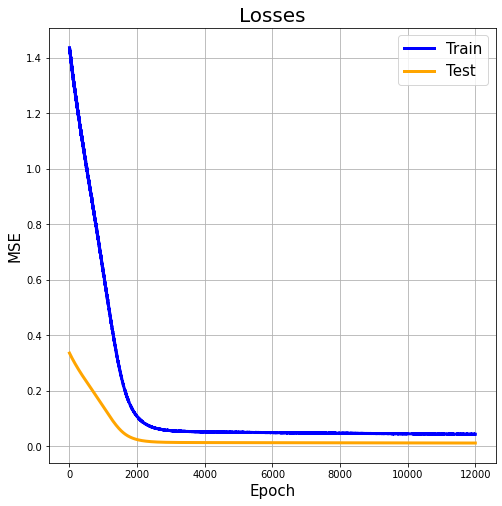

In [26]:
plt.figure(figsize=(8, 8))
plt.plot(epoch_stats['train'], color='blue', linewidth=3, label='Train')
plt.plot(epoch_stats['test'], color='orange', linewidth=3, label='Test')
plt.grid(True)
plt.xlabel('Epoch', fontdict={'fontsize': 15})
plt.ylabel('MSE', fontdict={'fontsize': 15})
plt.title('Losses', fontdict={'fontsize': 20})
plt.legend(fontsize=15)
plt.show()

# Determine anomaly threshold for data with anomalies

In [27]:
# Let's use trained model on data with anomalies and check what is a threshold for MSE when trying to reconstruct this data...

In [28]:
df_anomalies.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
8,0.569231,0.563636,0.517241,0.355372,0.569231,0.609091,0.505263,0.367188,0.5625,0.689320,...,0.511111,0.368,0.553846,0.621359,0.484211,0.328125,0.615385,0.582524,0.452632,0.328125
9,0.569231,0.609091,0.517241,0.355372,0.569231,0.645455,0.547368,0.335938,0.5625,0.650485,...,0.511111,0.336,0.615385,0.582524,0.452632,0.328125,0.615385,0.582524,0.452632,0.296875
10,0.569231,0.645455,0.563218,0.322314,0.569231,0.609091,0.421053,0.367188,0.5625,0.601942,...,0.477778,0.336,0.615385,0.582524,0.452632,0.296875,0.553846,0.582524,0.484211,0.328125
11,0.507692,0.609091,0.425287,0.322314,0.507692,0.563636,0.463158,0.367188,0.5000,0.601942,...,0.511111,0.336,0.553846,0.582524,0.452632,0.296875,0.492308,0.582524,0.410526,0.296875
12,0.507692,0.563636,0.471264,0.355372,0.507692,0.563636,0.505263,0.367188,0.5625,0.650485,...,0.477778,0.304,0.492308,0.582524,0.410526,0.296875,0.492308,0.504854,0.326316,0.257812


# Split dataset into train (to estimate threshold) and test (to test this threshold)

In [29]:
split_idx = int(0.7 * len(df_anomalies))
train_df_anomalies = df_anomalies[:split_idx]
test_df_anomalies = df_anomalies[split_idx:]

# Dataset and dataloader for data with anomalies

In [30]:
train_ds_anomalies = SatelliteDataset(train_df_anomalies.values)
train_dl_anomalies = torch.utils.data.DataLoader(train_ds_anomalies, batch_size=512)

test_ds_anomalies = SatelliteDataset(test_df_anomalies.values)
test_dl_anomalies = torch.utils.data.DataLoader(test_ds_anomalies, batch_size=512)

# Create anomalies detector once again and load trained weights

In [31]:
an_det = SatelliteAnomalyModel(in_features=len(df_anomalies.columns))
an_det.load_state_dict(torch.load('anomaly_detector_weights.pth'))

<All keys matched successfully>

# Loop through train dataloader and get MSE

In [32]:
an_det.to(device)
an_det.eval()
mse_anomalies = []
test_crit = nn.MSELoss(reduction='none')
for batch_id, x in enumerate(train_dl_anomalies):
    x = x.to(device, dtype=torch.float)
    outputs = an_det(x)
    loss = list(test_crit(outputs, x).mean(dim=1).to('cpu').detach().numpy())
    mse_anomalies += loss
mse_anomalies = np.array(mse_anomalies)

In [33]:
print(mse_anomalies.min())
print(mse_anomalies.max())

0.0014534009
0.25102285


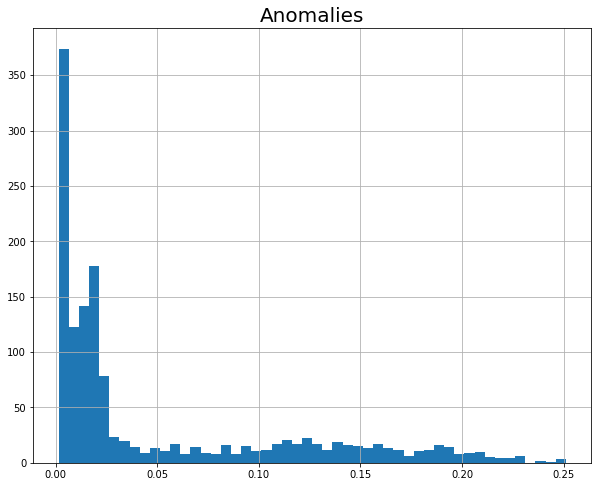

In [34]:
plt.figure(figsize=(10, 8))
hist_mse_anomalies, bin_edges_anomalies, patches_anomalies = plt.hist(mse_anomalies, bins=50)
plt.grid(True)
plt.title('Anomalies', fontdict={'fontsize': 20})
plt.show()

In [35]:
# Let's do it for test data without anomalies
mse_no_anomalies = []
for batch_id, x in enumerate(test_dl_no_anomalies):
    x = x.to(device, dtype=torch.float)
    outputs = an_det(x)
    loss = list(test_crit(outputs, x).mean(dim=1).to('cpu').detach().numpy())
    mse_no_anomalies += loss
mse_no_anomalies = np.array(mse_no_anomalies)

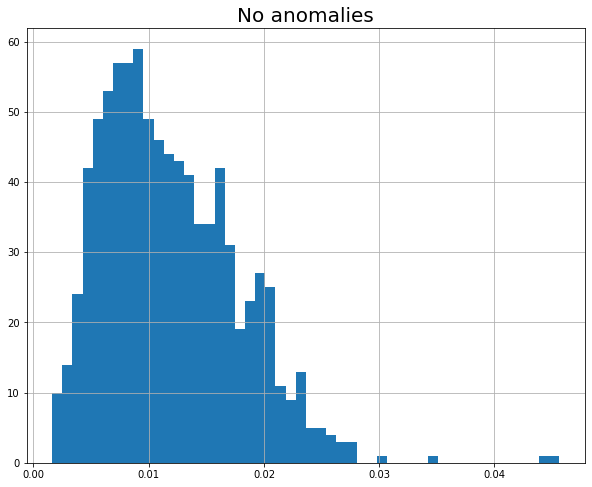

In [36]:
plt.figure(figsize=(10, 8))
hist_mse_no_anomalies, bin_edges_no_anomalies, patches_no_anomalies = plt.hist(mse_no_anomalies, bins=50)
plt.grid(True)
plt.title('No anomalies', fontdict={'fontsize': 20})
plt.show()

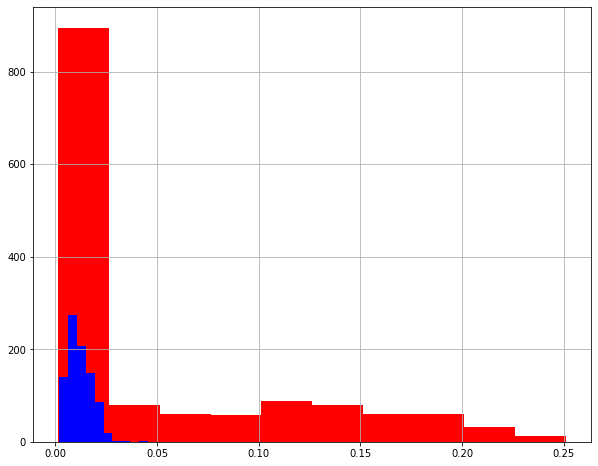

In [37]:
plt.figure(figsize=(10, 8))
plt.hist(mse_anomalies, color='red')
plt.hist(mse_no_anomalies, color='blue')
plt.grid(True)
plt.show()

In [38]:
# Hmmm, it is a little tricky problem, let's try threshold of 0.02 and see what is accuracy

In [39]:
threshold = 0.02

In [40]:
no_correct_classifications = 0
for batch_id, x in enumerate(test_dl_anomalies):
    x = x.to(device, dtype=torch.float)
    outputs = an_det(x)
    loss = test_crit(outputs, x).mean(dim=1).to('cpu').detach().numpy()
    loss = loss > threshold
    no_correct_classifications += loss.sum()

In [41]:
print(f'Accuracy: {no_correct_classifications / len(test_ds_anomalies)}')

Accuracy: 0.4500818330605565


In [42]:
# Accuracy is not so good, but you have to look on figure with both distributions on the same plot.
# All data points which are not anomalies lies between 0 - 0.05... but in the same region lies a lot of data points 
# with anomalies, so it's very hard to determine good threshold for this problem with that approach.
# One solution might be to use deeper network which could catch some more relations between features.